Goal - determine viscosity of liquid using video

### import libraries

In [10]:
import cv2
import os
import pathlib
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

np.set_printoptions(threshold=sys.maxsize)

### change path

In [11]:
path = os.path.abspath('')
os.chdir(f'{path}')

### save video as frames

In [12]:
video_number = 1

video_file_name = f'Gasoline_{video_number}.mp4'

video_frames_dict = {}

pathlib.Path(f'video{video_number}').mkdir(parents=True,exist_ok=True)

file_name = f"C:\\Gun's Stuff\\Coding\\Image Processing\\image processing script\\video\\{video_file_name}"

video = cv2.VideoCapture(file_name)
success,image = video.read()
count = 0

while success:

    cv2.imwrite(f'video{video_number}\\frame{count}.jpg',image)
    success,image = video.read()
    count += 1

video_frames_dict[video_number] = count

print(video_frames_dict)

{1: 350}


### image processing function

In [13]:
brightness_enhancer_value = 1.5
contrast_enhancer_value = 6

In [14]:
def image_processing(image):

    brightness_enhancer = ImageEnhance.Brightness(image)
    image = brightness_enhancer.enhance(brightness_enhancer_value) # to reduce brightness by 50%, use factor 0.5

    contrast_enhancer = ImageEnhance.Contrast(image)
    image = contrast_enhancer.enhance(contrast_enhancer_value)

    image = image.convert('1')

    image = image.filter(ImageFilter.BLUR)

    image_width, image_height = image.size
    image = image.crop(((100,320,image_width-300,image_height-300))) # (left,upper,right,lower)

    return image

### save black and white image

In [15]:
video_number = 1

video_file_name = f'Gasoline_{video_number}.mp4'

video_frames_dict = {}

pathlib.Path(f'videobw{video_number}').mkdir(parents=True,exist_ok=True)

file_name = f"C:\\Gun's Stuff\\Coding\\Image Processing\\image processing script\\video\\{video_file_name}"

video = cv2.VideoCapture(file_name)
success,image = video.read()
count = 0

while success:

    image = Image.fromarray(image)
    image = image_processing(image)
    image = np.asarray(image).astype(np.uint8)*255

    cv2.imwrite(f'videobw{video_number}\\frame{count}.jpg',image)
    success,image = video.read()
    count += 1

video_frames_dict[video_number] = count

print(video_frames_dict)

{1: 350}


### process

In [16]:
for video_number,video_total_frames in video_frames_dict.items():

    folder_name = f"C:\\Gun's Stuff\\Coding\\Image Processing\\image processing script V2\\video{video_number}" 

    for frame in range(video_total_frames):

        image = Image.open(f'{folder_name}\\frame{frame}.jpg')

        image = image_processing(image)

        image.save(f'videobw{video_number}\\frame{frame}.jpg')

image number 237
cluster 0 - x centroid: 54.559322033898304
cluster 0 - y centroid: 56.3728813559322
cluster 1 - x centroid: 55.13513513513514
cluster 1 - y centroid: 37.21621621621622
distance from each centroid: 19.16531711198032
image number 238
cluster 0 - x centroid: 52.0625
cluster 0 - y centroid: 78.54166666666667
cluster 1 - x centroid: 54.559322033898304
cluster 1 - y centroid: 56.3728813559322
distance from each centroid: 22.308948034867008
image number 239
cluster 0 - x centroid: 48.69230769230769
cluster 0 - y centroid: 101.46153846153847
cluster 1 - x centroid: 52.0625
cluster 1 - y centroid: 78.54166666666667
distance from each centroid: 23.1663272722326


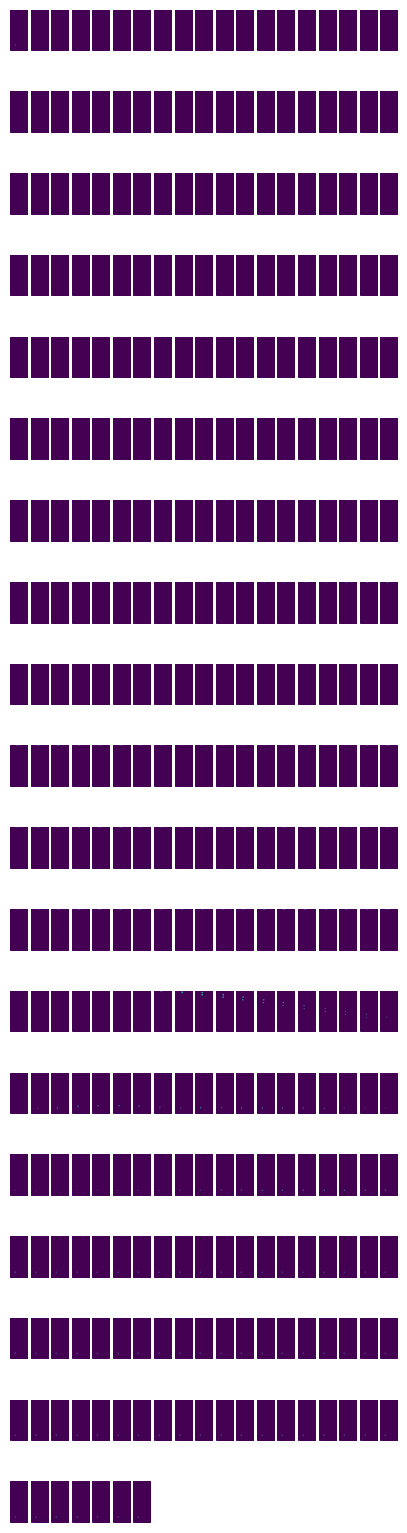

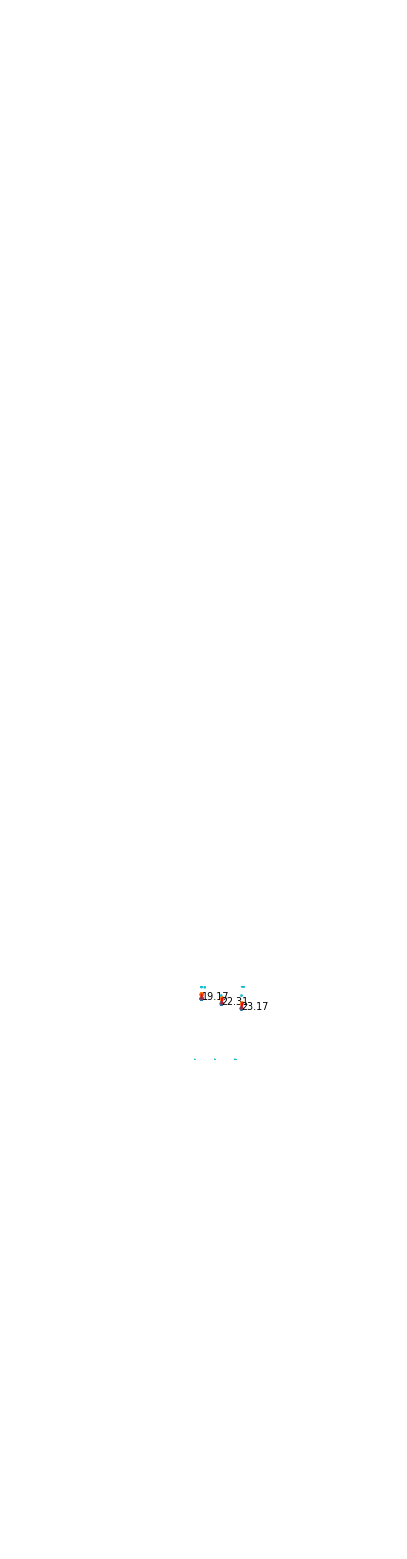

In [17]:
fig = plt.figure(figsize=(5,20))
fig2 = plt.figure(figsize=(5,20))

amount_of_axes = int(np.ceil(np.sqrt(video_frames_dict[1])))
current_row = 0
current_col = -1

amount_of_frames = video_frames_dict[1]

color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']

distance_list = []

for image_number in range(amount_of_frames):

    if image_number != amount_of_frames - 1:

        current_frame = image_number
        next_frame = current_frame + 1

        if image_number == amount_of_frames - 1:

            current_frame = image_number
            next_frame = current_frame       

        current_col += 1

        if current_col == amount_of_axes:

            current_row += 1
            current_col = 0

        ax = plt.subplot2grid((amount_of_axes,amount_of_axes),(current_row,current_col),fig=fig)

        image_0 = Image.open(f'videobw{video_number}\\frame{current_frame}.jpg')
        image_1 = Image.open(f'videobw{video_number}\\frame{next_frame}.jpg')

        image_0 = ImageOps.invert(image_0)
        image_1 = ImageOps.invert(image_1)

        image_0_numpy_array = np.array(image_0)    
        image_1_numpy_array = np.array(image_1)

        difference_between_image_0_and_1 = image_0_numpy_array + image_1_numpy_array

        difference_between_image_0_and_1[difference_between_image_0_and_1 > 255/2] = 255
        difference_between_image_0_and_1[difference_between_image_0_and_1 <= 255/2] = 0

        # show image

        ax.imshow(array_to_image)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.axis('off')

        # DBSCAN

        df_points = pd.DataFrame(difference_between_image_0_and_1)
        
        df_points[df_points > 1] = 1

        point_array = []

        for df_col in df_points.columns: 

            for df_row in df_points.index:

                if df_points[df_col].loc[df_row] == 1:

                    point_array.append([df_col,df_row])

        array_to_image = Image.fromarray(difference_between_image_0_and_1)

        DBSCAN_model = DBSCAN(eps=10,min_samples=30)
        DBSCAN_model.fit(point_array)

        clusters = DBSCAN_model.labels_

        ax2 = plt.subplot2grid((amount_of_axes,amount_of_axes),(current_row,current_col),fig=fig2)

        x_y_coordinate_df = pd.DataFrame(point_array,columns=['x','y'])
        x_y_coordinate_df['clusters'] = clusters

        unique_clusters_set = set(clusters)
        unique_clusters_list = list(unique_clusters_set)

        unique_color_code_list = []

        for unique_color in unique_clusters_list:

            unique_color_code_list.append(color_cycler[unique_color])

        df_color_list = []

        for df_row in x_y_coordinate_df['clusters'].index:

            cluster = x_y_coordinate_df['clusters'].loc[df_row]

            df_color_list.append(unique_color_code_list[unique_clusters_list.index(cluster)])

        x_y_coordinate_df['color'] = df_color_list

        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.set_xlim(ax.get_xlim())
        ax2.set_ylim(ax.get_ylim())
        ax2.axis('off')

        if len(unique_color_code_list) > 2 and -1 not in unique_color_code_list:

            print(f'image number {image_number}')

            cluster_0_df = x_y_coordinate_df[x_y_coordinate_df['clusters'] == 0]
            cluster_1_df = x_y_coordinate_df[x_y_coordinate_df['clusters'] == 1]

            cluster_0_x = cluster_0_df['x'].mean()
            cluster_0_y = cluster_0_df['y'].mean()
            cluster_1_x = cluster_1_df['x'].mean()
            cluster_1_y = cluster_1_df['y'].mean()

            print(f'cluster 0 - x centroid: {cluster_0_x}')
            print(f'cluster 0 - y centroid: {cluster_0_y}')
            print(f'cluster 1 - x centroid: {cluster_1_x}')
            print(f'cluster 1 - y centroid: {cluster_1_y}')

            print(f'distance from each centroid: {((cluster_0_x-cluster_1_x)**2+(cluster_0_y-cluster_1_y)**2)**0.5}')

            ax2.scatter(x_y_coordinate_df['x'],x_y_coordinate_df['y'],color=x_y_coordinate_df['color'],s=1)
            ax2.plot([cluster_0_x,cluster_1_x],[cluster_0_y,cluster_1_y],color='red')

            distance_list.append(((cluster_0_x-cluster_1_x)**2+(cluster_0_y-cluster_1_y)**2)**0.5)

            ax2.text(cluster_0_x,cluster_0_y,f'{((cluster_0_x-cluster_1_x)**2+(cluster_0_y-cluster_1_y)**2)**0.5:.2f}',fontsize='x-small')

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.show()

to get liquid viscosity, the free body diagram equation for Fbuoyancy, Fdrag, and Fgravity can be arranged to be:

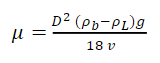

where D is ball diameter, Pb is density of ball, Pl is density of liquid, g is gravity (9.8 m<sup>2</sup>/s), and v is ball velocity

video is 29.97 frames per second (check in properties -> details tab of video)

In [18]:
distance = max(distance_list)

frames_per_second = 29.97
graph_height = ax.get_ylim()[0]
column_height = 38.1
seconds_per_frame = 1/frames_per_second

print(f'the average distance traveled is: {distance} pixels')
print(f'graph height is: {graph_height} pixels')
print(f'converting to cm (column is {column_height:.0f}cm tall): {(distance/graph_height)*column_height} cm')
print(f'1 second has {frames_per_second:.0f} frames ({frames_per_second:.0f} fps)')
print(f'therefore, 1 frame is 1/{frames_per_second:.0f} seconds')
print(f'taking the amount distance traveled ({(distance/graph_height)*column_height} cm) divided by time (1/{frames_per_second:.0f} seconds)')
print(f'the velocity would be equal to {((distance/graph_height)*column_height) / (seconds_per_frame)} cm/s')
print(f'or {(((distance/graph_height)*column_height) / (seconds_per_frame)) / 100} m/s')

ball_velocity = (((distance/graph_height)*column_height) / (seconds_per_frame)) / 100

the average distance traveled is: 23.1663272722326 pixels
graph height is: 339.5 pixels
converting to cm (column is 38cm tall): 2.599814636442009 cm
1 second has 30 frames (30 fps)
therefore, 1 frame is 1/30 seconds
taking the amount distance traveled (2.599814636442009 cm) divided by time (1/30 seconds)
the velocity would be equal to 77.91644465416701 cm/s
or 0.77916444654167 m/s


assuming ball density to be 3165kg/m<sup>3</sup>  (stainless steel), liquid density to be 737.2kg/m<sup>3</sup> (gasoline), and D to be 0.015m

In [19]:
ball_density = 3165 #kg/m^3
liquid_density = 737.2 #kg/m^3
ball_diameter = 0.015 #m
gravity = 9.8 #m/s^2

liquid_viscosity = ((ball_diameter**2)*(ball_density-liquid_density)*(gravity))/(18*ball_velocity) # kg/m*s or pascal seconds

print(f'the estimated liquid viscosity is {liquid_viscosity:.2f} kg/m*s (pascal seconds)')

the estimated liquid viscosity is 0.38 kg/m*s (pascal seconds)
